In [1]:
!pip install ultralytics paho-mqtt opencv-python-headless gitpython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 2.0 MB/s eta 0:00:00


In [2]:
import base64
import json
import cv2
import numpy as np
import paho.mqtt.client as mqtt
from ultralytics import YOLO
import os
from git import Repo
import time
from google.colab import files  # Jika dijalankan di Colab
from IPython.display import Image, display  # Untuk menampilkan hasil di Colab
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# ### 1. Clone Repository dan Pindah ke Direktori
repo_url = "https://github.com/Muhammad-Ikhwan-Fathulloh/Learn-Object-Detection-with-Yolo.git"
repo_dir = "Learn-Object-Detection-with-Yolo"

if not os.path.exists(repo_dir):
    Repo.clone_from(repo_url, repo_dir)
    print(f"Cloned repository to {repo_dir}")
else:
    print(f"Repository {repo_dir} already exists")

# Pindah ke direktori repository
os.chdir(repo_dir)

Cloned repository to Learn-Object-Detection-with-Yolo


In [4]:
# ### 2. Pastikan Model Tersedia
model_path = "best_model.pt"  # Sesuaikan path jika berbeda

if not os.path.exists(model_path):
    print(f"Model {model_path} tidak ditemukan. Pastikan model telah diunggah atau dilatih.")
else:
    print(f"Model {model_path} ditemukan.")

Model best_model.pt ditemukan.


In [5]:
# ### 3. Konfigurasi MQTT Shiftr.io
MQTT_BROKER = "public.cloud.shiftr.io"
MQTT_PORT = 1883
MQTT_USERNAME = "public"
MQTT_PASSWORD = "public"
INPUT_TOPIC = "stream-ingestion"
OUTPUT_TOPIC = "ai-result"

# ### 4. Inisialisasi Model YOLOv8
model = YOLO(model_path)

In [6]:
# ### 5. Definisi Fungsi

def decode_base64_image(encoded_data):
    """Decodes a base64 encoded image back to OpenCV format."""
    image_data = base64.b64decode(encoded_data)
    np_arr = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
    return img

def encode_base64_image(image_path):
    """Encodes an image file to base64 format."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def process_image(image):
    """Runs the YOLOv8 model on the image and returns results."""
    results = model(image)
    detected_objects = []

    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            detected_object = {"xyxy": [x1, y1, x2, y2]}
            detected_objects.append(detected_object)

    return detected_objects

In [7]:
# ### 6. Unggah Gambar

def upload_image_colab():
    """Upload image file using Google Colab's file upload feature."""
    uploaded = files.upload()  # Mengunggah file menggunakan widget Colab
    if not uploaded:
        print("No file uploaded.")
        return None

    # Ambil file pertama yang diunggah
    for filename in uploaded.keys():
        print(f"Uploaded file: {filename}")
        return filename

In [8]:
# ### 7. Fungsi Tambahan untuk Pengujian Lokal

def test_local_image(image_path):
    """Test model on a locally uploaded image and publish results."""
    if not os.path.exists(image_path):
        print(f"File {image_path} tidak ditemukan.")
        return

    print(f"Processing image {image_path}...")
    image = cv2.imread(image_path)
    objects = process_image(image)

    print("Detection Results:")
    print(json.dumps({"objects": objects}, indent=2))

    # Simpan hasil deteksi dengan bounding box
    for obj in objects:
        x1, y1, x2, y2 = obj["xyxy"]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    output_path = "detection_result.jpg"
    cv2.imwrite(output_path, image)
    print(f"Saved result to {output_path}")

    # Tampilkan gambar hasil deteksi
    display_detected_image(image)

    # Publish the result to MQTT
    publish_detection_result(objects)

def publish_detection_result(objects):
    """Publish object detection results via MQTT."""
    result = json.dumps({"objects": objects})
    client.publish(OUTPUT_TOPIC, result)
    print(f"Published AI result to '{OUTPUT_TOPIC}': {result}")

def display_detected_image(image):
    """Display the detected image with bounding boxes using matplotlib."""
    # Convert BGR image to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

In [9]:
# ### 8. Inisialisasi MQTT Client

client = mqtt.Client()
client.username_pw_set(MQTT_USERNAME, MQTT_PASSWORD)

# MQTT callbacks
def on_connect(client, userdata, flags, rc):
    if rc == 0:
        print("Connected to MQTT Broker!")
        client.subscribe(INPUT_TOPIC)
        print(f"Subscribed to topic '{INPUT_TOPIC}'")
    else:
        print(f"Failed to connect, return code {rc}")

def on_message(client, userdata, message):
    try:
        print(f"Message received on topic: {message.topic}")
        encoded_image = message.payload.decode("utf-8")
        image = decode_base64_image(encoded_image)
        objects = process_image(image)
        result = json.dumps({"objects": objects})
        client.publish(OUTPUT_TOPIC, result)
        print(f"Published AI result to '{OUTPUT_TOPIC}': {result}")
    except Exception as e:
        print(f"Error processing message: {e}")

client.on_connect = on_connect
client.on_message = on_message
client.connect(MQTT_BROKER, MQTT_PORT, keepalive=60)
client.loop_start()

<ipython-input-9-9d723d880ccc>:3: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

Upload an image for detection (or type 'exit' to stop):


Saving image1.jpg to image1 (1).jpg
Uploaded file: image1 (1).jpg
Processing image1 (1).jpg...
Processing image image1 (1).jpg...

0: 384x640 10 masks, 2 no-masks, 129.9ms
Speed: 7.1ms preprocess, 129.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Detection Results:
{
  "objects": [
    {
      "xyxy": [
        329,
        67,
        1237,
        1247
      ]
    },
    {
      "xyxy": [
        2484,
        524,
        2967,
        1136
      ]
    },
    {
      "xyxy": [
        1410,
        301,
        1723,
        721
      ]
    },
    {
      "xyxy": [
        2030,
        380,
        2278,
        769
      ]
    },
    {
      "xyxy": [
        61,
        499,
        378,
        1019
      ]
    },
    {
      "xyxy": [
        1657,
        755,
        2057,
        1276
      ]
    },
    {
      "xyxy": [
        2862,
        487,
        3132,
        942
      ]
    },
    {
      "xyxy": [
        3022,
        743,
        3412,
  

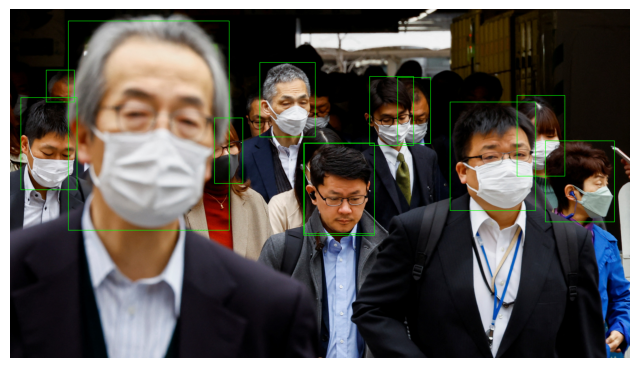

Published AI result to 'ai-result': {"objects": [{"xyxy": [329, 67, 1237, 1247]}, {"xyxy": [2484, 524, 2967, 1136]}, {"xyxy": [1410, 301, 1723, 721]}, {"xyxy": [2030, 380, 2278, 769]}, {"xyxy": [61, 499, 378, 1019]}, {"xyxy": [1657, 755, 2057, 1276]}, {"xyxy": [2862, 487, 3132, 942]}, {"xyxy": [3022, 743, 3412, 1200]}, {"xyxy": [2188, 385, 2374, 758]}, {"xyxy": [204, 344, 363, 524]}, {"xyxy": [1662, 757, 2057, 1266]}, {"xyxy": [1154, 614, 1314, 983]}]}
Detection completed for image1 (1).jpg.
Do you want to upload another image? (y/n): n
Exiting the image upload loop.


In [11]:
# ### 9. Mengunggah dan Memproses Gambar Secara Terus-Menerus

def process_until_done():
    while True:
        print("Upload an image for detection (or type 'exit' to stop):")
        uploaded_filename = upload_image_colab()  # Unggah gambar
        if uploaded_filename:
            print(f"Processing {uploaded_filename}...")
            test_local_image(uploaded_filename)  # Proses gambar
            print(f"Detection completed for {uploaded_filename}.")
        else:
            print("No image uploaded. Retrying...")

        # Menanyakan apakah pengguna ingin mengunggah gambar lagi atau keluar
        user_input = input("Do you want to upload another image? (y/n): ").lower()
        if user_input != 'y':
            print("Exiting the image upload loop.")
            break
        time.sleep(1)  # Delay kecil agar tidak terus-menerus tanpa jeda

# Panggil fungsi untuk memulai proses
process_until_done()